### compute vs auroc (fig 2)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tueplots import bundles, axes

plt.style.use('default')
plt.rcParams.update({"figure.dpi": 300})
plt.rcParams['text.usetex'] = False
print(bundles.neurips2023())
sns.set_palette("colorblind")

###############################################################################
# 1. FLOPs Computation (DeepMind style)
###############################################################################
def deepmind_flops_per_sequence(n_layers, n_heads, d_model, n_ctx, n_vocab, ff_ratio=4):
    """
    Compute forward+backward FLOPs for a decoder-only Transformer.
    """
    d_attn = d_model // n_heads
    d_ff = d_model * ff_ratio

    embeddings = 2 * n_ctx * n_vocab * d_model

    attn_qkv = 2 * n_ctx * 3 * d_model * (d_attn * n_heads)
    attn_logits = 2 * n_ctx * n_ctx * (d_attn * n_heads)
    attn_softmax = 3 * n_heads * n_ctx * n_ctx
    attn_reduce = 2 * n_ctx * n_ctx * (d_attn * n_heads)
    attn_project = 2 * n_ctx * (d_attn * n_heads) * d_model
    total_attn = attn_qkv + attn_logits + attn_softmax + attn_reduce + attn_project

    ff = 2 * n_ctx * (d_model * d_ff + d_model * d_ff)
    logits = 2 * n_ctx * d_model * n_vocab

    forward_flops = embeddings + n_layers * (total_attn + ff) + logits
    return 3 * forward_flops  # forward + backward

###############################################################################
# 2. Model Parameters
###############################################################################
model_params = {
    'Llama3.1 405B': {
        'n_layers': 126, 'n_heads': 128, 'd_model': 16384,
        'n_ctx': 512, 'n_vocab': 128000, 'ff_ratio': 3.25
    },
    'Llama3.1 70B': {
        'n_layers': 80,  'n_heads': 64,  'd_model': 8192,
        'n_ctx': 512, 'n_vocab': 128000, 'ff_ratio': 3.5
    },
    'Llama3.1 8B': {
        'n_layers': 32,  'n_heads': 32,  'd_model': 4096,
        'n_ctx': 512, 'n_vocab': 128000, 'ff_ratio': 3.5
    },
    'Gemma2 9B': {
        'n_layers': 42,  'n_heads': 16,  'd_model': 3584,
        'n_ctx': 512, 'n_vocab': 256128, 'ff_ratio': 8
    }
}

###############################################################################
# 3. Methods & Compute Cost
###############################################################################
average_claims = 50
k_values = [2, 3, 5, 10]

def compute_method_costs(params, k_values):
    flops_seq = deepmind_flops_per_sequence(**params)
    costs = {}

    # Single-run (point) methods
    costs['FP']           = average_claims * flops_seq
    costs['SelfCheckGPT'] = average_claims * 2 * flops_seq
    costs['p(true)']      = (1 + 5 + 10) * average_claims * flops_seq

    # Series methods
    series_methods = {'SE': {}, 'Graph-based': {}, 'SC+VC': {}}
    for k in k_values:
        series_methods['SE'][k]          = 3 * (k**2) * average_claims * flops_seq
        series_methods['Graph-based'][k] = average_claims * k * (k + 1) * flops_seq
        series_methods['SC+VC'][k]       = average_claims * k * (k + 1) * flops_seq

    costs.update(series_methods)
    return costs

compute_costs_model = {
    model_name: compute_method_costs(model_params[model_name], k_values)
    for model_name in model_params
}

###############################################################################
# 4. Updated AUROC Data
###############################################################################
methods_series = ['SE', 'Graph-based', 'SC+VC']
methods_points = ['FP', 'SelfCheckGPT', 'p(true)']

data_series = {
    'Llama3.1 405B': {
        'SE': {
            2: 0.513330, 3: 0.534681, 5: 0.530481, 10: 0.525646
        },
        'Graph-based': {
            2: 0.57, 3: 0.62, 5: 0.66, 10: 0.72
        },
        'SC+VC': {
            2: 0.61, 3: 0.66, 5: 0.70, 10: 0.75
        },
    },
    'Llama3.1 70B': {
        'SE': {2: 0.48, 3: 0.53, 5: 0.56, 10: 0.58},
        'Graph-based': {2: 0.63, 3: 0.66, 5: 0.70, 10: 0.81},
        'SC+VC': {2: 0.61, 3: 0.65, 5: 0.71, 10: 0.81}
    },
    'Llama3.1 8B': {
        'SE': {2: 0.48, 3: 0.53, 5: 0.56, 10: 0.58},
        'Graph-based': {
            2: 0.5035937843, 3: 0.705,
            5: 0.69, 10: 0.80
        },
        'SC+VC': {
            2: 0.5572452229, 3: 0.6857264441,
            5: 0.733, 10: 0.831
        }
    },
    'Gemma2 9B': {
        'SE': {2: 0.48, 3: 0.53, 5: 0.56, 10: 0.58},
        'Graph-based': {2: 0.57, 3: 0.62, 5: 0.66, 10: 0.72},
        'SC+VC': {2: 0.61, 3: 0.66, 5: 0.70, 10: 0.75}
    }
}

data_series_std = {
    'Llama3.1 405B': {
        'SE': {2: 0.025, 3: 0.027, 5: 0.029, 10: 0.029},
        'Graph-based': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0},
        'SC+VC': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0}
    },
    'Llama3.1 70B': {
        'SE': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0},
        'Graph-based': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0},
        'SC+VC': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0}
    },
    'Llama3.1 8B': {
        'SE': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0},
        'Graph-based': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0},
        'SC+VC': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0}
    },
    'Gemma2 9B': {
        'SE': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0},
        'Graph-based': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0},
        'SC+VC': {2: 0.0, 3: 0.0, 5: 0.0, 10: 0.0}
    }
}

points_data = {
    'Llama3.1 405B': {
        'p(true)': 0.704,     # ± 0.027
        'SelfCheckGPT': 0.5758, # ± 0.020
        'FP': 0.7579          # ± 0.0107
    },
    'Llama3.1 70B': {
        'p(true)': 0.6229,
        'SelfCheckGPT': 0.5407,
        'FP': 0.7453
    },
    'Llama3.1 8B': {
        'p(true)': 0.6927,
        'SelfCheckGPT': 0.6018,
        'FP': 0.7357
    },
    'Gemma2 9B': {
        'p(true)': 0.6048,
        'SelfCheckGPT': 0.5495,
        'FP': 0.7357
    }
}

Llama3.1 405B {'p(true)': 8.883258846609408e+17, 'SelfCheckGPT': 1.110407355826176e+17, 'FP': 5.55203677913088e+16, 'FP+': 5.55203677913088e+16, 'SE': {2: 6.662444134957056e+17, 3: 1.4990499303653376e+18, 5: 4.16402758434816e+18, 10: 1.665611033739264e+19}, 'Graph-based': {2: 3.331222067478528e+17, 3: 6.662444134957056e+17, 5: 1.665611033739264e+18, 10: 6.107240457043968e+18}, 'SC+VC': {2: 3.331222067478528e+17, 3: 6.662444134957056e+17, 5: 1.665611033739264e+18, 10: 6.107240457043968e+18}}
Llama3.1 70B {'p(true)': 1.51948426739712e+17, 'SelfCheckGPT': 1.8993553342464e+16, 'FP': 9496776671232000.0, 'FP+': 9496776671232000.0, 'SE': {2: 1.13961320054784e+17, 3: 2.56412970123264e+17, 5: 7.122582503424e+17, 10: 2.8490330013696e+18}, 'Graph-based': {2: 5.6980660027392e+16, 3: 1.13961320054784e+17, 5: 2.8490330013696e+17, 10: 1.04464543383552e+18}, 'SC+VC': {2: 5.6980660027392e+16, 3: 1.13961320054784e+17, 5: 2.8490330013696e+17, 10: 1.04464543383552e+18}}
Llama3.1 8B {'p(true)': 1.742232008

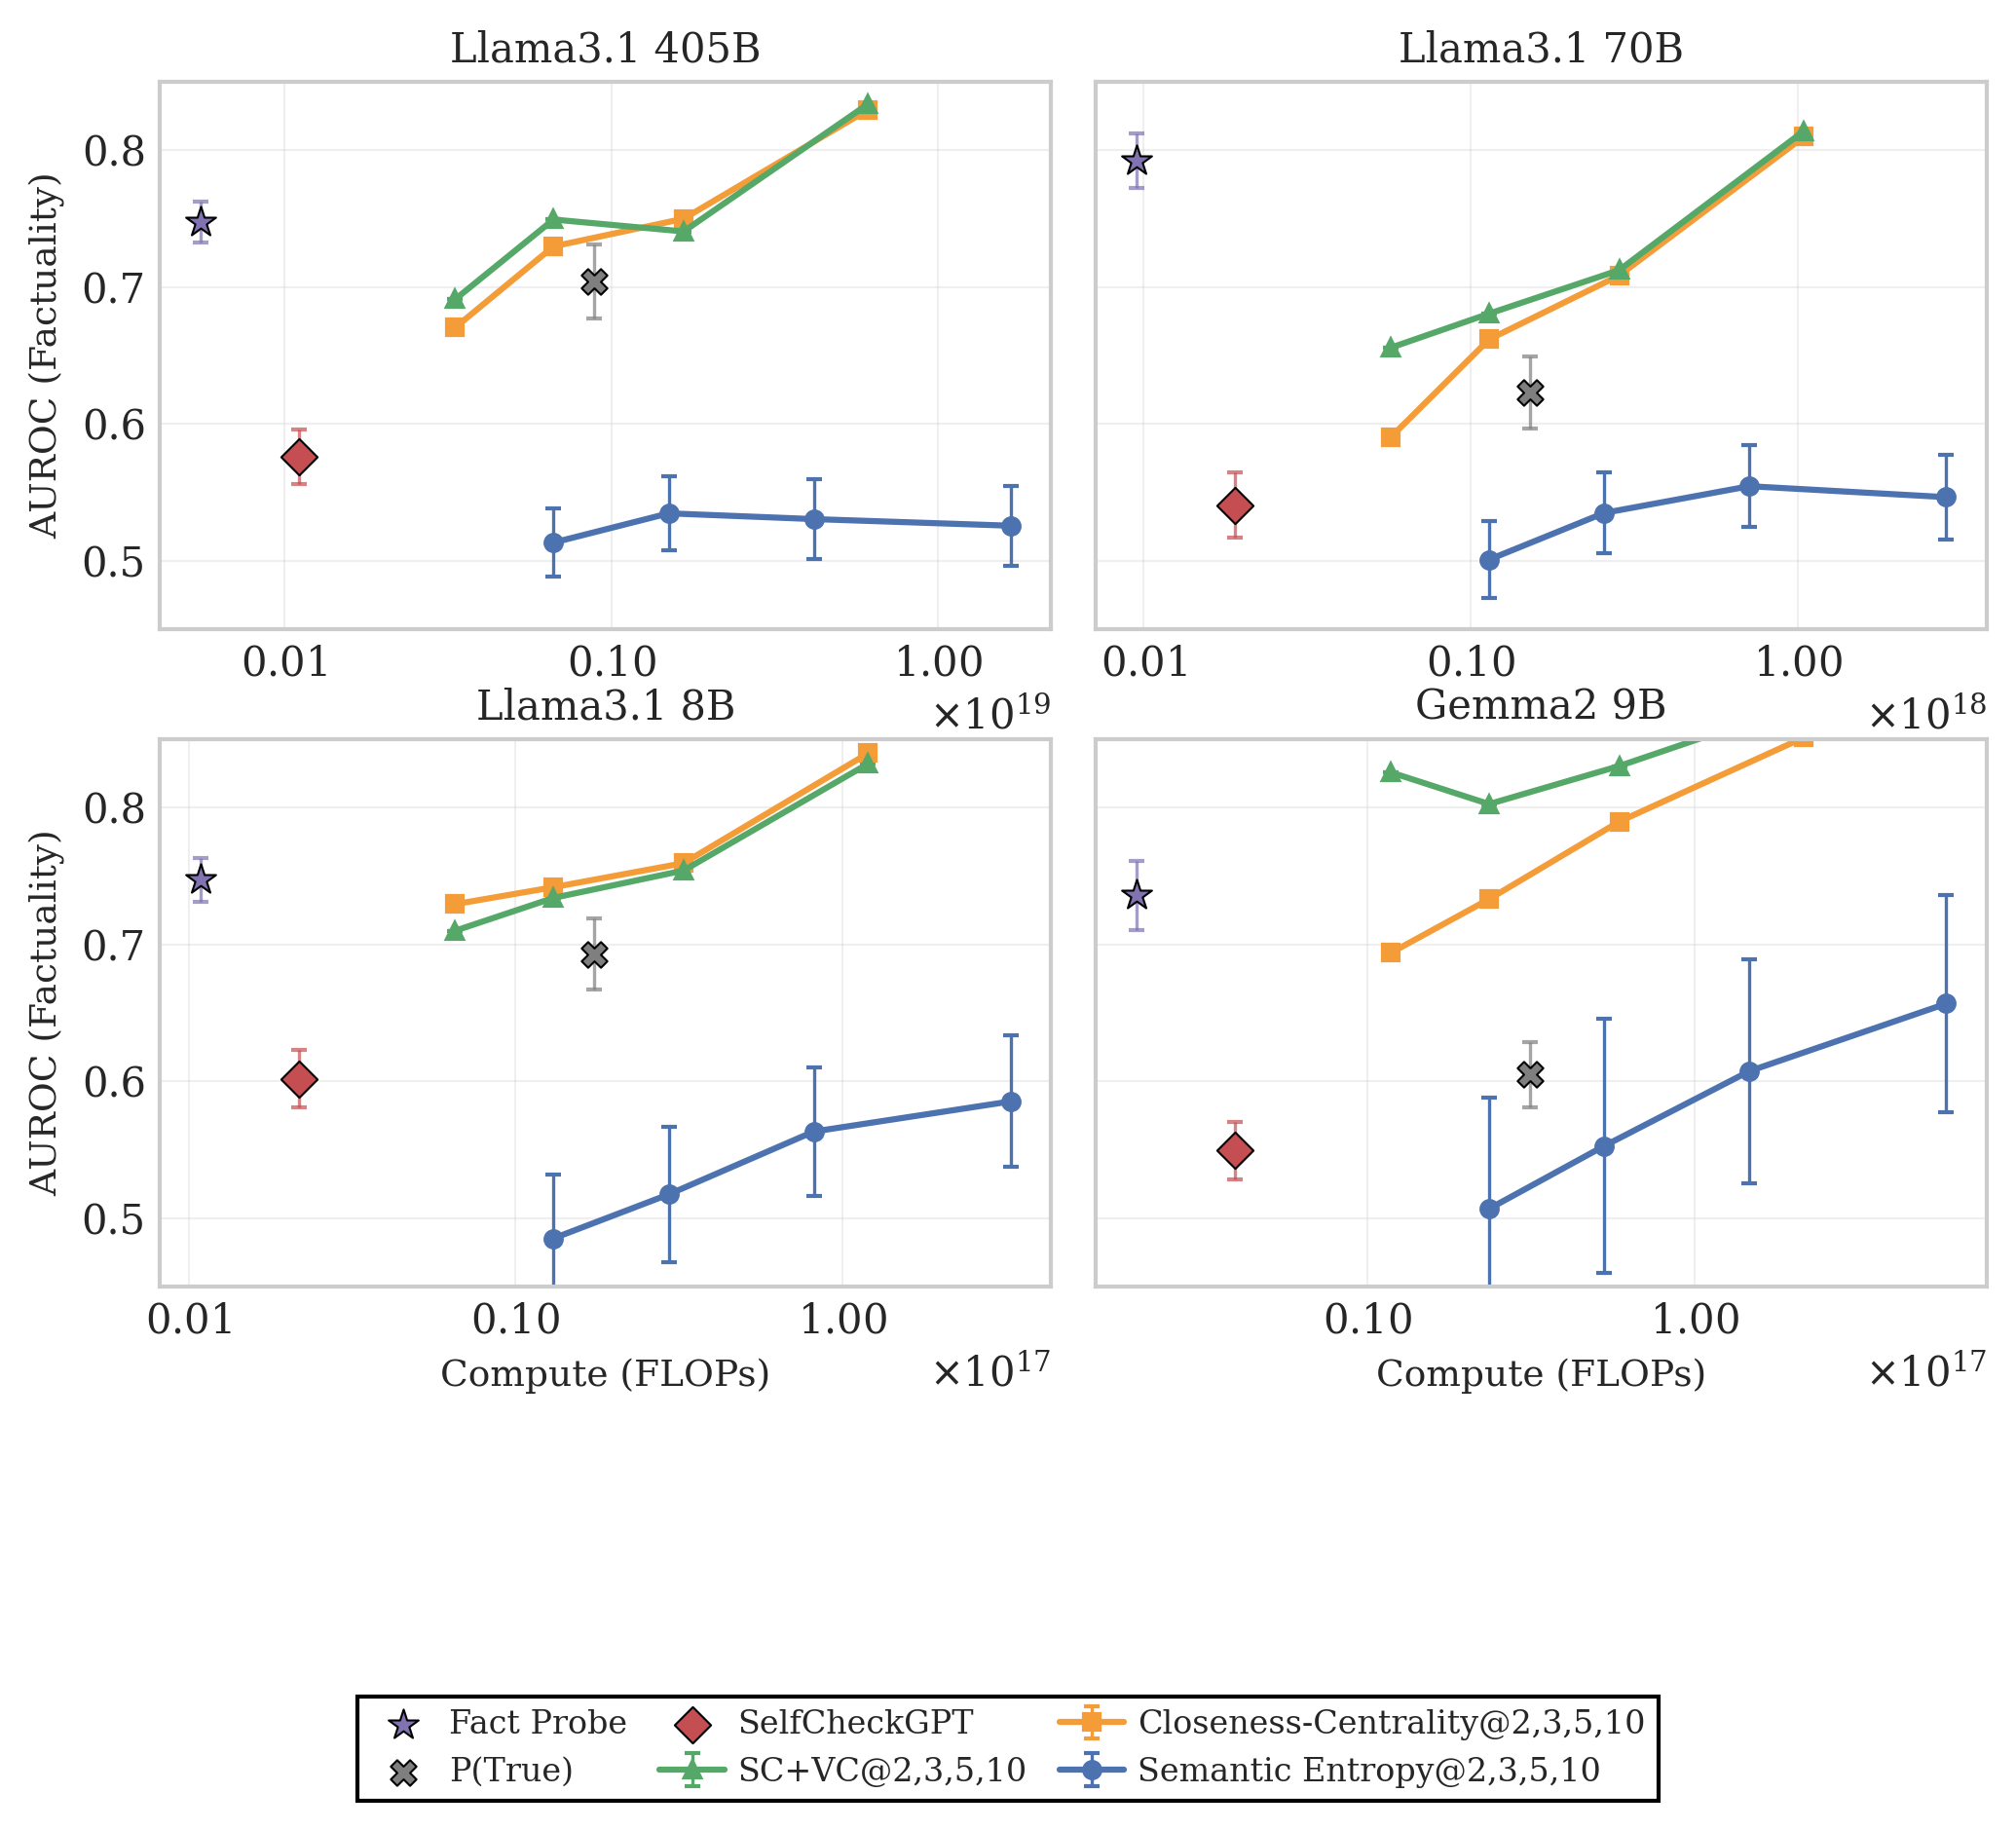

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

def plot_colm_style():
    """
    Create a publication-quality plot suitable for COLM conference submission.
    Modified to include Gemma2 9B model and use a 2x2 grid layout.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif'],
        'font.size': 10,
        'axes.labelsize': 14,
        'axes.titlesize': 15,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 16,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'axes.grid': True,
        'grid.alpha': 0.3
    })
    
    # Add Gemma2 9B to the model list
    model_list = ['Llama3.1 405B', 'Llama3.1 70B', 'Llama3.1 8B', 'Gemma2 9B']
    
    # Change figure layout to 2x2 grid with square dimensions
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5), sharey=True, constrained_layout=False)
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Define academic notation for method names
    method_display_names = {
        'SE': 'Semantic Entropy@2,3,5,10',
        'Graph-based': 'Closeness-Centrality@2,3,5,10',
        'SC+VC': 'SC+VC@2,3,5,10',
        'p(true)': 'P(True)',
        'SelfCheckGPT': 'SelfCheckGPT',
        'FP': 'Fact Probe'
        # Removed 'FP+': 'Fact Probe+'
    }
    
    # Define styling with academic color palette
    line_styles = {
        'SE': ('o-', '#4C72B0', 1.0),      # Blue - Semantic Entropy
        'Graph-based': ('s-', '#F39C38', 1.0),  # Orange - Closeness-Centrality
        'SC+VC': ('^-', '#55A868', 1.0)     # Green - SC+VC
    }
    
    # Point method formatting with smaller markers
    point_markers = {
        'p(true)': ('X', '#7F7F7F', 40),      # Gray
        'SelfCheckGPT': ('D', '#C44E52', 40),  # Red
        'FP': ('*', '#8172B2', 60)          # Purple
        # Removed 'FP+': ('P', '#764EAA', 60)  # Dark purple
    }
    
    for i, model in enumerate(model_list):
        ax = axes[i]
        
        # Plot series methods with error bars
        flops_dict = compute_costs_model[model]
        print(model, flops_dict)
        for method in methods_series:
            x_vals = [flops_dict[method][k] for k in k_values]
            y_vals = [data_series[model][method][k] for k in k_values]
            y_errs = [data_series_std[model][method][k] for k in k_values]

            line_fmt, color, alpha = line_styles[method]
            ax.errorbar(
                x_vals, y_vals, yerr=y_errs, fmt=line_fmt,
                color=color, capsize=2, elinewidth=0.8, markersize=4, 
                label=method_display_names[method], alpha=alpha, zorder=1
            )

        # Plot point methods with error bars
        for method in methods_points:
            # Skip FP+ method
            if method == 'FP+':
                continue
                
            x_val = flops_dict[method]
            y_val = points_data[model][method]
            yerr = points_data_std[model][method]
            marker, color, size = point_markers[method]
            
            # Error bars
            ax.errorbar(
                x_val, y_val, yerr=yerr,
                fmt='none', ecolor=color, capsize=2, elinewidth=0.8,
                alpha=0.7, zorder=2
            )
            
            # Marker
            ax.scatter(
                x_val, y_val, marker=marker, color=color, 
                s=size, label=method_display_names[method], edgecolor='black', linewidth=0.5,
                zorder=3
            )
        
        # Set title and axes labels
        ax.set_title(model, fontsize=10, pad=5)
        ax.set_xscale('log')
        
        # Only set x-label for the bottom row (index 2 and 3)
        if i >= 2:
            ax.set_xlabel('Compute (FLOPs)', fontsize=9)
        
        # Only set y-label for the left column (index 0 and 2)
        if i % 2 == 0:
            ax.set_ylabel('AUROC (Factuality)', fontsize=9)
        
        # Set y-axis limits
        ax.set_ylim([0.45, 0.85])
        
        # Format x-axis for scientific notation (suitable for academic papers)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-1, 1))
        ax.xaxis.set_major_formatter(formatter)
        
        # Set clean gridlines
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Set white background (preferred for academic papers)
        ax.set_facecolor('white')
        
    # Create legend with proper ordering for academic paper
    handles, labels = axes[0].get_legend_handles_labels()
    
    # Academic ordering of methods - removed Fact Probe+
    preferred_order = ['Fact Probe', 'P(True)', 'SelfCheckGPT', 
                      'SC+VC@2,3,5,10', 'Closeness-Centrality@2,3,5,10', 'Semantic Entropy@2,3,5,10']
    ordered_handles = []
    ordered_labels = []
    
    for method in preferred_order:
        if method in labels:
            idx = labels.index(method)
            ordered_handles.append(handles[idx])
            ordered_labels.append(labels[idx])
    
    # Create a single legend for all subplots with academic styling
    # COLM/ACL papers typically prefer compact legends with clear separation
    legend = fig.legend(
        ordered_handles, ordered_labels, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.13),  # Adjusted for 2x2 layout
        ncol=3,  # Changed from 4 to 3 columns since we removed one method
        columnspacing=1.0,
        frameon=True, 
        fontsize=8,
        fancybox=False,
        shadow=False,
        framealpha=1.0,
        edgecolor='black',
        handletextpad=0.4,  # Compact spacing between handle and text
        borderpad=0.4  # Padding inside legend border
    )
    
    # Adjust layout for academic paper formatting and 2x2 grid
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.2, bottom=0.2, top=0.95)
    
    # Save high-quality figure in formats suitable for COLM submission
    plt.savefig('./figures/fp_auroc_vs_flops.pdf', dpi=450, bbox_inches='tight')
    
    return fig

# Run the plot
if __name__ == '__main__':
    plot_colm_style()

### performance scaling plot (original fig 2; now become a table)

![](./figures/scaling_id_ood_table.png)

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Computer Modern Roman
findfont: Generic family 'serif' not found because none of the follow

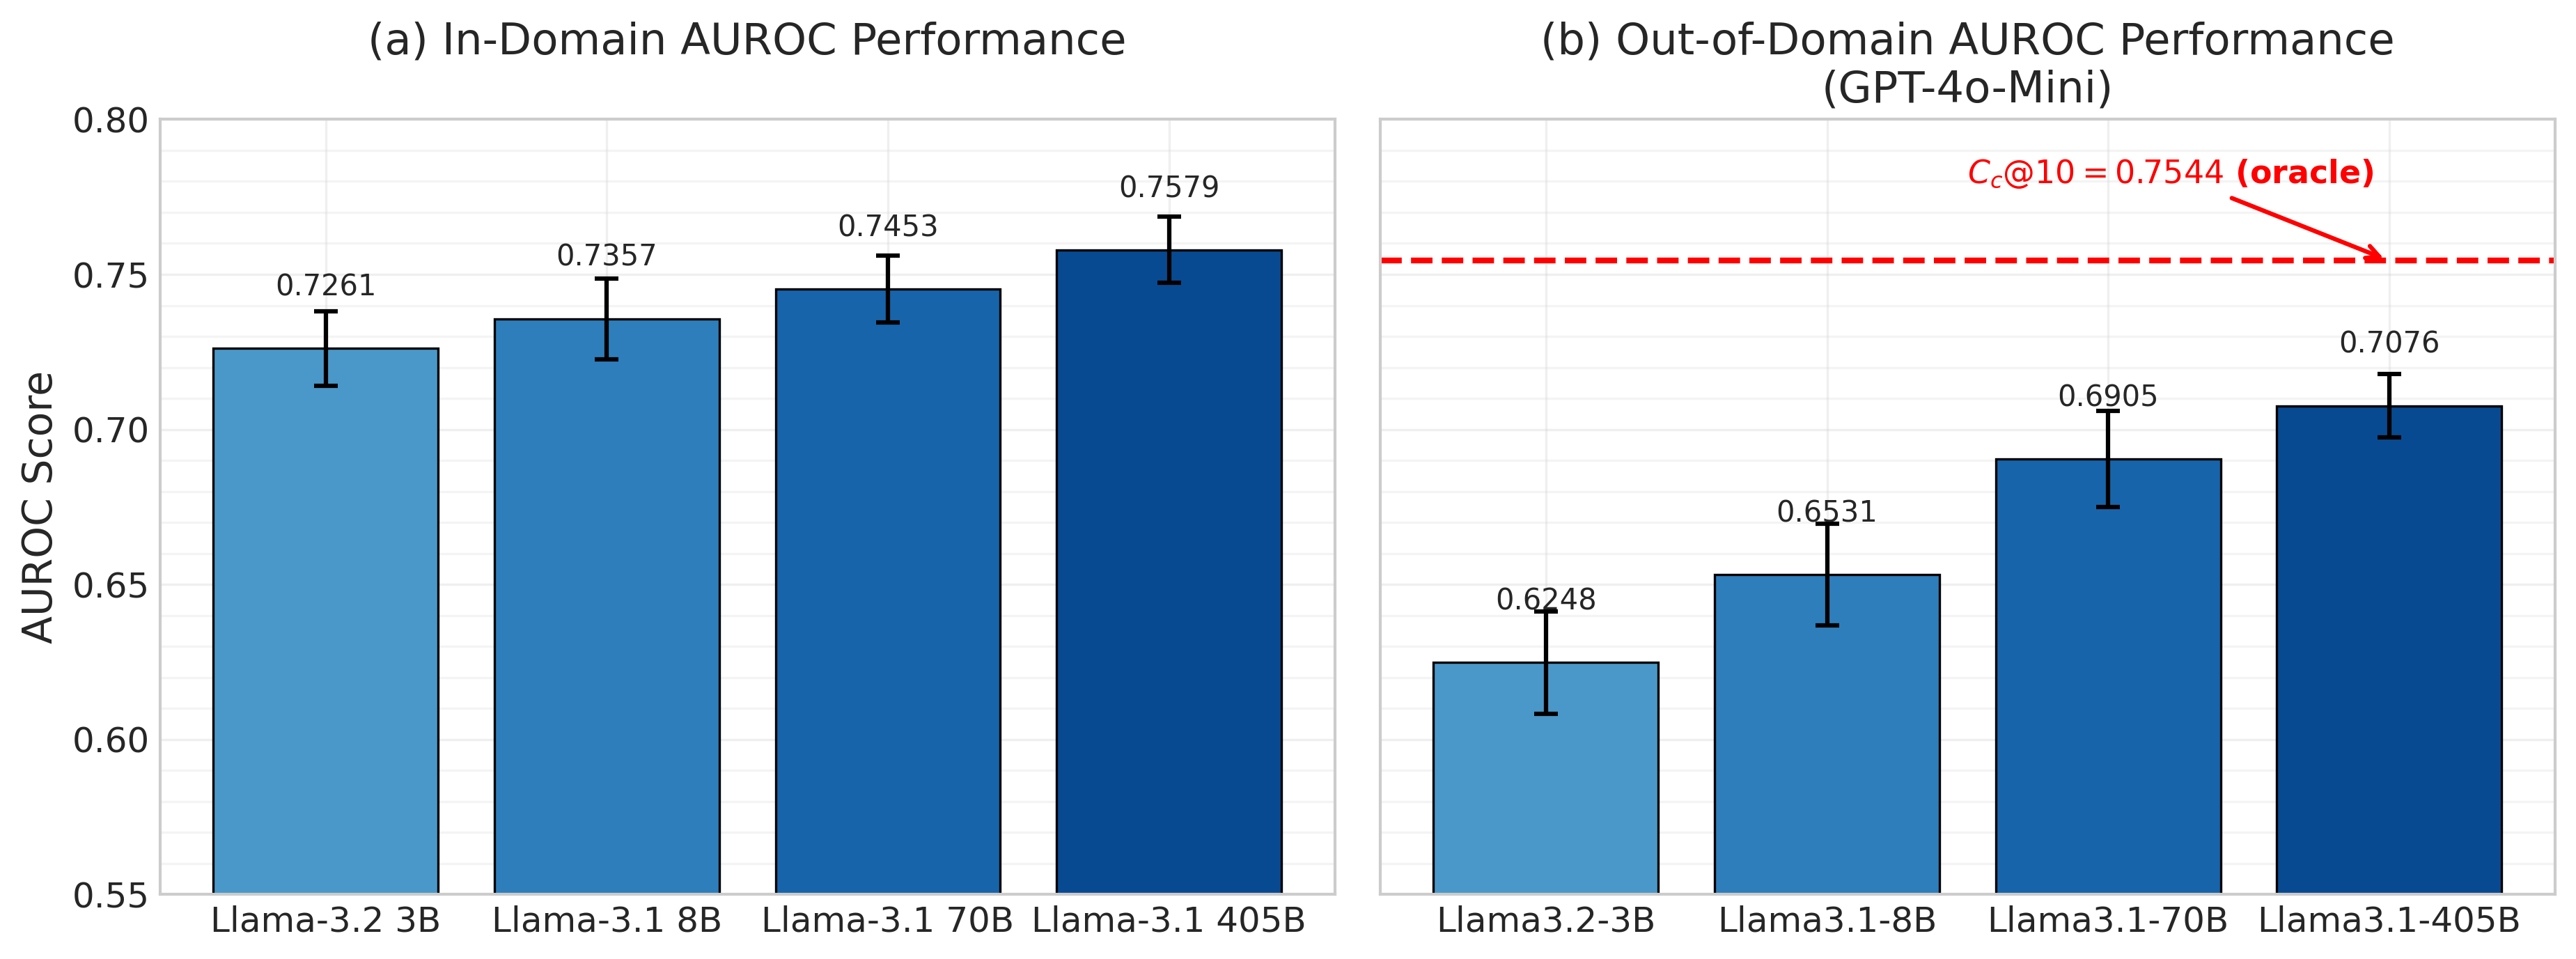

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

# Set style for COLM paper visualization (more academic and clean)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 16,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3
})

    # plt.rcParams.update({
    #     'font.family': 'serif',
    #     'font.serif': ['Times New Roman', 'Computer Modern Roman'],
    #     'font.size': 9,
    #     'mathtext.fontset': 'stix',
    #     'axes.titlesize': 10,
    #     'axes.labelsize': 9,
    #     'xtick.labelsize': 8,
    #     'ytick.labelsize': 8,
    #     'legend.fontsize': 8,
    #     'axes.linewidth': 0.8,
    #     'lines.linewidth': 1.5,
    #     'lines.markersize': 5,
    #     'figure.dpi': 300,
    #     'text.usetex': False,  # Set to True if using LaTeX
    #     'axes.grid': True,
    #     'grid.alpha': 0.3,
    #     'axes.axisbelow': True,
    #     'xtick.major.width': 0.8,
    #     'ytick.major.width': 0.8,
    #     'xtick.minor.width': 0.6,
    #     'ytick.minor.width': 0.6,
    # })
    

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5), sharey=True)

# ========== First Plot: In-Distribution AUROC ==========

# Data for in-distribution performance
models_id = ['Llama-3.2 3B', 'Llama-3.1 8B', 'Llama-3.1 70B', 'Llama-3.1 405B']
auroc_means = [0.7261, 0.7357, 0.7453, 0.7579]
auroc_std = [0.012, 0.013, 0.0107, 0.0107]

# Create a color gradient from lighter to darker blue
colors = plt.cm.Blues(np.linspace(0.6, 0.9, len(models_id)))

# Plot bars for in-distribution performance
bars1 = ax1.bar(models_id, auroc_means, yerr=auroc_std, capsize=4, 
               color=colors, edgecolor='black', linewidth=0.8,
               error_kw={'elinewidth': 1.5, 'capthick': 1.5})

# Add labels and title
ax1.set_title('(a) In-Domain Tokens\n')
ax1.set_ylabel('AUROC Score')
ax1.set_ylim(0.55, 0.80)  # Set y-axis limits for better visualization
ax1.yaxis.set_minor_locator(MultipleLocator(0.01))
ax1.grid(which='minor', alpha=0.2)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.015,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# ========== Second Plot: Out-of-Distribution AUROC ==========

# Data for OOD performance - keeping only GPT-4o-Mini
ood_data = [
    # Only keeping GPT-4o-Mini data as requested
    {'Model': 'Llama3.1-8B', 'Testing Platform': 'GPT-4o-Mini', 'Mean': 0.6531, 'Std': 0.0164},
    {'Model': 'Llama3.2-3B', 'Testing Platform': 'GPT-4o-Mini', 'Mean': 0.6248, 'Std': 0.0165},  
    {'Model': 'Llama3.1-70B', 'Testing Platform': 'GPT-4o-Mini', 'Mean': 0.6905, 'Std': 0.0155}, 
    {'Model': 'Llama3.1-405B', 'Testing Platform': 'GPT-4o-Mini', 'Mean': 0.7076, 'Std': 0.0102},
]

# Convert to DataFrame
df = pd.DataFrame(ood_data)

# Define platforms - only GPT-4o-Mini as requested
platforms = ['GPT-4o-Mini']

# Define model names in the desired order
model_names = ['Llama3.2-3B', 'Llama3.1-8B', 'Llama3.1-70B', 'Llama3.1-405B']

# Define colors for GPT-4o-Mini
platform_colors = {
    'GPT-4o-Mini': '#3f51b5'  # Academic blue shade
}

# Calculate the positions for the bars - since there's only one platform, no need for multiple positions
r = np.arange(len(model_names))

# Create grouped bars for GPT-4o-Mini
platform_data = df[df['Testing Platform'] == 'GPT-4o-Mini']
means = []
errors = []

# Get data in correct order
for model in model_names:
    model_data = platform_data[platform_data['Model'] == model]
    if not model_data.empty:
        means.append(model_data['Mean'].values[0])
        errors.append(model_data['Std'].values[0])
    else:
        means.append(0)
        errors.append(0)

# Create a color gradient similar to the first plot
ood_colors = plt.cm.Blues(np.linspace(0.6, 0.9, len(model_names)))

bars2 = ax2.bar(model_names, means, yerr=errors, capsize=4,
        color=ood_colors, edgecolor='black', linewidth=0.8,
        error_kw={'elinewidth': 1.5, 'capthick': 1.5})

# Set labels and title for OOD plot
ax2.set_title('(b) Out-of-Domain Tokens\n(GPT-4o-Mini)')
# ax2.set_ylabel('AUROC Score')
# ax2.set_ylim(0.55, 0.75)  # Set y-axis limits for better visualization
ax2.yaxis.set_minor_locator(MultipleLocator(0.01))
ax2.grid(which='minor', alpha=0.2)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.015,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# ========== Add constant line for closeness-centrality method ==========
closeness_centrality_value = 0.7544276113356925

# Add constant line to the right plot (ax2)
ax2.axhline(y=closeness_centrality_value, color='red', linestyle='--', linewidth=2)

# Add annotation for the constant line
ax2.annotate('$C_c @10 = 0.7544$ (oracle)', 
            xy=(len(model_names)-1, closeness_centrality_value),
            xytext=(len(model_names)-2.5, closeness_centrality_value + 0.025),
            color='red', fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle="->", color='red', lw=1.5))

# Add a main title for the entire figure
# fig.suptitle('Scaling Performance of Llama Models Across Domains', fontweight='bold', y=0.98)

# Tighten layout and add spacing for the main title
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save with high resolution
plt.savefig('./figures/scaling_id_ood_auroc.pdf', dpi=450, bbox_inches='tight')
# plt.savefig('llama_performance_colm.png', dpi=300, bbox_inches='tight')
plt.show()

### tab5: activation clamping improves factuality

![](./figures/steering_table.png)

In [2]:
import numpy as np
from scipy.stats import ttest_rel

# Define the data from the table
# Before steering scores
before_scores = np.array([
    0.286,  # Llama 3.2-3B FactScore
    0.538,  # Llama 3.2-3B LongFact F1
    0.599,  # Llama 3.1-8B FactScore
    0.588,  # Llama 3.1-8B LongFact F1
    0.568,  # Llama 3.1-70B FactScore
    0.606   # Gemma 2-9B FactScore
])

# After steering scores
after_scores = np.array([
    0.316,  # Llama 3.2-3B FactScore
    0.553,  # Llama 3.2-3B LongFact F1
    0.664,  # Llama 3.1-8B FactScore
    0.622,  # Llama 3.1-8B LongFact F1
    0.609,  # Llama 3.1-70B FactScore
    0.627   # Gemma 2-9B FactScore
])

# Verify all paired data is valid
assert len(before_scores) == len(after_scores)
assert not np.any(np.isnan(before_scores)) 
assert not np.any(np.isnan(after_scores))

# Print differences for each pair to verify improvements
differences = after_scores - before_scores
print("Differences (After - Before):")
for i, diff in enumerate(differences):
    print(f"Pair {i+1}: {diff:.4f}")
print(f"Mean difference: {np.mean(differences):.4f}")

# Perform paired t-test (one-sided, "greater" means "after > before")
t_stat, p_value = ttest_rel(
    after_scores, 
    before_scores,
    alternative='greater'  # alternative hypothesis: after scores are greater than before scores
)

print("\nPaired t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {len(before_scores) - 1}")

# Interpret results
alpha = 0.05  # standard significance level
if p_value < alpha:
    print(f"\nThe improvement is statistically significant (p < {alpha}).")
else:
    print(f"\nThe improvement is not statistically significant (p >= {alpha}).")

Differences (After - Before):
Pair 1: 0.0300
Pair 2: 0.0150
Pair 3: 0.0650
Pair 4: 0.0340
Pair 5: 0.0410
Pair 6: 0.0210
Mean difference: 0.0343

Paired t-test results:
t-statistic: 4.7683
p-value: 0.002511
Degrees of freedom: 5

The improvement is statistically significant (p < 0.05).


### rejection-accuracy curve (fig 3)

![](./figures/rejection_accuracy.png)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Configure matplotlib for publication-quality figures (COLM style)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'figure.figsize': (7, 5),  # Standard for many conference submissions
    'axes.linewidth': 0.5,     # Thinner axis borders
    'lines.linewidth': 2.0,    # Default line width
    'lines.markersize': 6,
    'text.usetex': False       # Set to True if using LaTeX
})

# Color scheme following COLM/ACL/NLP conference standards
# Using colorblind-friendly, print-friendly colors
colors = {
    'llama70b': '#0072B2',  # Dark blue - visible when printed
    'gemma9b': '#9467BD',   # Purple - visible in print and colorblind-safe
    'llama8b': '#D55E00',   # Orange-red - high contrast and colorblind-safe
    'llama3b': '#009E73'    # Green - good contrast and prints well
}

# Data from Llama 3.1 70B
llama70b_data = {
    'model': 'Llama-3.1 70B',
    'fact_score': 0.714,
    'rejection_ratio': [0.0, 0.09907120743034059, 0.19969040247678016, 0.29721362229102166, 
                       0.3993808049535603, 0.48452012383900933, 0.5743034055727554, 
                       0.5743034055727554, 1.0, 1.0, 1.0],
    'accuracy': [0.7383900928792569, 0.7749140893470791, 0.804642166344294, 0.8348017621145375, 
                0.8608247422680413, 0.8918918918918919, 0.9018181818181819, 
                0.9018181818181819, 1.0, 1.0, 1.0]
}

# Data from Llama 3.1 8B
llama8b_data = {
    'model': 'Llama-3.1 8B',
    'fact_score': 0.541,
    'rejection_ratio': [0.0, 0.09941520467836262, 0.19883040935672514, 0.29759584145549056, 
                       0.4015594541910331, 0.5152696556205328, 0.6224821312540612, 
                       0.6224821312540612, 0.6224821312540612, 1.0, 1.0],
    'accuracy': [0.5750487329434698, 0.5909090909090909, 0.6180048661800487, 0.6401480111008325, 
                0.6742671009771987, 0.6997319034852547, 0.7383820998278829, 
                0.7383820998278829, 0.7383820998278829, 1.0, 1.0]
}

# Data from Llama 3.2 3B
llama3b_data = {
    'model': 'Llama-3.2 3B',
    'fact_score': 0.335,
    'rejection_ratio': [0.0, 0.09908944831280131, 0.1997857525441885, 0.2961971076593466, 
                       0.40385645420460636, 0.5056239957150509, 0.6063202999464381, 
                       0.7129084092126405, 0.8328869844670594, 0.8328869844670594, 1.0],
    'accuracy': [0.5066952329941082, 0.5101070154577884, 0.5026773761713521, 0.5068493150684932, 
                0.5130278526504941, 0.5287107258938245, 0.5496598639455782, 
                0.5671641791044776, 0.6089743589743589, 0.6089743589743589, 1.0]
}

# Data from Gemma2 9B
gemma2_9b_data = {
    'model': 'Gemma-2 9B',
    'fact_score': 0.561,
    'rejection_ratio': [0.0, 0.09892879647132957, 0.20919974795211094, 0.28418399495904223,
                       0.3516068052930057, 0.46250787649653435, 0.46250787649653435,
                       0.46250787649653435, 1.0, 1.0, 1.0],
    'accuracy': [0.5759294265910523, 0.6055944055944056, 0.6430278884462152, 0.6637323943661971,
                0.685131195335277, 0.7256740914419695, 0.7256740914419695,
                0.7256740914419695, 1.0, 1.0, 1.0]
}

# Create figure with conference-appropriate dimensions
fig, ax = plt.subplots(facecolor='white')
ax.set_facecolor('white')

# Plot curves with publication-friendly line styles and markers
# Add markers at data points for better readability in print
ax.plot(llama70b_data['rejection_ratio'], llama70b_data['accuracy'], 
        color=colors['llama70b'], linewidth=2.5, marker='o', markersize=4, 
        markevery=0.15, label=llama70b_data['model'])

ax.plot(gemma2_9b_data['rejection_ratio'], gemma2_9b_data['accuracy'], 
        color=colors['gemma9b'], linewidth=2.5, marker='^', markersize=5, 
        markevery=0.15, label=gemma2_9b_data['model'])

ax.plot(llama8b_data['rejection_ratio'], llama8b_data['accuracy'], 
        color=colors['llama8b'], linewidth=2.5, marker='s', markersize=4, 
        markevery=0.15, label=llama8b_data['model'])

ax.plot(llama3b_data['rejection_ratio'], llama3b_data['accuracy'], 
        color=colors['llama3b'], linewidth=2.5, marker='d', markersize=4, 
        markevery=0.15, label=llama3b_data['model'])

# Fill areas with publication-appropriate opacity
# Lower opacity for better print results
ax.fill_between(llama70b_data['rejection_ratio'], 0.3, llama70b_data['accuracy'], 
                alpha=0.15, color=colors['llama70b'])

ax.fill_between(gemma2_9b_data['rejection_ratio'], 0.3, gemma2_9b_data['accuracy'], 
                alpha=0.15, color=colors['gemma9b'])

ax.fill_between(llama8b_data['rejection_ratio'], 0.3, llama8b_data['accuracy'], 
                alpha=0.15, color=colors['llama8b'])

ax.fill_between(llama3b_data['rejection_ratio'], 0.3, llama3b_data['accuracy'], 
                alpha=0.15, color=colors['llama3b'])

# Add fact score indicators with different line styles for better differentiation
ax.axhline(y=llama70b_data['fact_score'], color=colors['llama70b'], linestyle='--', linewidth=1.5, alpha=0.7)
ax.axhline(y=gemma2_9b_data['fact_score'], color=colors['gemma9b'], linestyle='-.', linewidth=1.5, alpha=0.7)
ax.axhline(y=llama8b_data['fact_score'], color=colors['llama8b'], linestyle=':', linewidth=1.5, alpha=0.7)
ax.axhline(y=llama3b_data['fact_score'], color=colors['llama3b'], linestyle='--', linewidth=1.5, alpha=0.7)

# Add fact score labels with publication-quality spacing and text
# Using lighter boxes and optimizing for readability
def add_fact_label(ax, y, text, color, x_pos=0.05, y_offset=0.01):
    ax.text(x_pos, y + y_offset, text,
           bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.3', 
                    linewidth=1, alpha=0.85),
           fontsize=10, color='black', fontweight='normal')

add_fact_label(ax, llama70b_data['fact_score'], 
              f"70B FActScore: {llama70b_data['fact_score']:.3f}", colors['llama70b'], y_offset=0.02)
add_fact_label(ax, gemma2_9b_data['fact_score'], 
              f"9B FActScore: {gemma2_9b_data['fact_score']:.3f}", colors['gemma9b'], y_offset=0.02)
add_fact_label(ax, llama8b_data['fact_score'], 
              f"8B FActScore: {llama8b_data['fact_score']:.3f}", colors['llama8b'], y_offset=-0.04)
add_fact_label(ax, llama3b_data['fact_score'], 
              f"3B FActScore: {llama3b_data['fact_score']:.3f}", colors['llama3b'], y_offset=0.02)

# Set axis labels with standard conference format
ax.set_xlabel('Rejection Ratio (fraction of data rejected)')
ax.set_ylabel('Accuracy on retained data')
# ax.set_title('Model Accuracy vs. Rejection Ratio')

# Set axis limits
ax.set_xlim([0, 1.0])
ax.set_ylim([0.3, 1.01])

# Add grid suitable for publication
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.5, color='gray')

# Create a legend with appropriate styling for conference publication
legend = ax.legend(
    loc='lower right',
    frameon=True,
    framealpha=0.8,
    edgecolor='gray',
    fancybox=True,
    fontsize=10
)
legend.get_frame().set_linewidth(0.5)

# Clean up tick marks to publication standards
ax.tick_params(direction='out', length=4, width=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout for proper margins
plt.tight_layout()

# Save with publication-quality settings
plt.savefig('colm_rejection_accuracy.pdf', bbox_inches='tight')
# plt.savefig('colm_rejection_accuracy.png', bbox_inches='tight', dpi=300)

print("Plot saved as 'colm_rejection_accuracy.pdf' and 'colm_rejection_accuracy.png'")

### Figure 4: Reversing training and testing dataset can cause worse probe generalization.


![](./figures/reverse_performance.png)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import numpy as np
from matplotlib.patches import Patch

# Configuration (replace with your actual paths/labels)
FIRST_RESULTS_PATH = 'long_form_factuality/fp_exps_all/llama3.1-8b_exp/metrics/Llama3.1-8B_xgboost_single_layer_longfact_gen_50_llama3_8b_test_Llama3.1-8B_fact_scores_nent_30_temp_0.5_maxtok_512_api_gpt-4o-mini_validation_and_test_aurocs.csv'
SECOND_RESULTS_PATH = 'long_form_factuality/fp_exps_all/llama3.1-8b_exp-rev/metrics/Llama3.1-8B_xgboost_single_layer_Llama3.1-8B_fact_scores_nent_30_temp_0.5_maxtok_512_api_gpt-4o-mini_test_longfact_gen_50_llama3_8b_validation_and_test_aurocs.csv'
FIRST_LABEL = 'Normal'
SECOND_LABEL = 'Reversed'
OUTPUT_DIR = './figures'
OUTPUT_NAME = 'reversed_comp'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load and prepare data
def prepare_data(file_path):
    """Load and prepare data from CSV file."""
    df = pd.read_csv(file_path)
    
    # Create Layer column if it doesn't exist
    if 'Layer' not in df.columns:
        if 'Start Layer' in df.columns and 'End Layer' in df.columns:
            df['Layer'] = (df['Start Layer'] + df['End Layer']) / 2
        elif 'Layer Group' in df.columns:
            df['Layer'] = df['Layer Group'].apply(
                lambda x: int(x.split('-')[0]) if isinstance(x, str) and '-' in x else x)
    
    # Standardize column names
    if 'Validation AUROC Mean' in df.columns and 'AUROC' not in df.columns:
        df['AUROC'] = df['Validation AUROC Mean']
    if 'Validation AUROC Std' in df.columns and 'AUROC_std' not in df.columns:
        df['AUROC_std'] = df['Validation AUROC Std']
    
    return df.sort_values('Layer')

# Load data
first_df = prepare_data(FIRST_RESULTS_PATH)
second_df = prepare_data(SECOND_RESULTS_PATH)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define datasets to plot
datasets = [
    # (dataframe, y_column, error_column, label, color, line_style, line_width)
    (first_df, 'Validation AUROC Mean', 'Validation AUROC Std', f"{FIRST_LABEL} Validation", '#1f77b4', '-o', 2.5),
    (first_df, 'Test AUROC', None, f"{FIRST_LABEL} Test", '#1f77b4', '--o', 2.5),
    (second_df, 'Validation AUROC Mean', 'Validation AUROC Std', f"{SECOND_LABEL} Validation", '#d62728', '-^', 2.5),
    (second_df, 'Test AUROC', None, f"{SECOND_LABEL} Test", '#d62728', '--^', 2.5)
]

# Plot each dataset and collect peak points
peak_points = []
all_y_values = []
all_y_errors = []

for df, y_col, yerr_col, label, color, fmt, lw in datasets:
    if y_col not in df.columns:
        continue
        
    # Plot with error bars if available
    if yerr_col and yerr_col in df.columns:
        yerr = df[yerr_col]
        ax.errorbar(df['Layer'], df[y_col], yerr=yerr, label=label, fmt=fmt, 
                   capsize=3, markersize=8, linewidth=lw, color=color, alpha=0.9)
        ax.fill_between(df['Layer'], df[y_col] - yerr, df[y_col] + yerr, color=color, alpha=0.1)
        all_y_errors.extend(yerr.dropna().values)
    else:
        ax.plot(df['Layer'], df[y_col], fmt, label=label, markersize=8, linewidth=lw, color=color, alpha=0.9)
    
    # Collect y-values for axis scaling
    all_y_values.extend(df[y_col].dropna().values)
    
    # Find peak point
    valid_idx = df[y_col].notna()
    if valid_idx.any():
        max_idx = df.loc[valid_idx, y_col].idxmax()
        max_row = df.loc[max_idx]
        peak_points.append({
            'x': max_row['Layer'], 
            'y': max_row[y_col],
            'value': max_row[y_col],
            'color': color,
            'label': label
        })

# Set axis properties
ax.set_xlabel('Layer', fontsize=22, fontweight='bold')
ax.set_ylabel('AUROC', fontsize=22, fontweight='bold')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Set y-axis limits with padding
if all_y_values:
    y_min = min(all_y_values) - (max(all_y_errors) if all_y_errors else 0)
    y_max = max(all_y_values) + (max(all_y_errors) if all_y_errors else 0)
    y_range = y_max - y_min
    ax.set_ylim(y_min - y_range*0.15, y_max + y_range*0.15)

# Annotate peak points
for point in peak_points:
    # Adjust annotation position based on location
    h_offset = 2 if point['x'] < 15 else -2
    
    ax.annotate(
        f"{point['label'].split()[0]}\nLayer {int(point['x'])}: {point['value']:.4f}",
        xy=(point['x'], point['y']),
        xytext=(point['x'] + h_offset, point['y'] + 0.02*y_range),
        arrowprops=dict(facecolor=point['color'], shrink=0.05, width=1.5, alpha=0.7),
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec=point['color'], alpha=0.95),
        fontsize=15,
        fontweight='bold'
    )

# Create legend
handles = []
labels = []

# Group by dataset
for dataset_label in [FIRST_LABEL, SECOND_LABEL]:
    handles.append(Patch(facecolor='white', edgecolor='black'))
    labels.append(f"{dataset_label}:")
    
    marker = 'o' if dataset_label == FIRST_LABEL else '^'
    color = '#1f77b4' if dataset_label == FIRST_LABEL else '#d62728'
    
    handles.append(plt.Line2D([0], [0], color=color, linestyle='-', marker=marker, markersize=8, linewidth=2.5))
    labels.append("Validation")
    
    handles.append(plt.Line2D([0], [0], color=color, linestyle='--', marker=marker, markersize=8, linewidth=2.5))
    labels.append("Test")

# Add legend
legend = ax.legend(handles=handles, labels=labels, loc='lower right', frameon=True, 
                  framealpha=0.95, edgecolor='black', fancybox=True, ncol=2)

# Finalize and display plot
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'{OUTPUT_NAME}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(OUTPUT_DIR, f'{OUTPUT_NAME}.png'), bbox_inches='tight')
plt.show()

### Sparse vs full probe (fig. 6)

![](./figures/sparse_vs_full_probe.png)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import numpy as np

# Configuration
RESULTS_DIR = './results'
MODEL_NAMES = ['Llama3.2-3B', 'Llama3.1-8B', 'Llama3.1-70B', 'Gemma2-9B']

# Configure plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 26,
    'axes.labelsize': 30,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'legend.fontsize': 24,
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

# Load data for all models
all_model_data = {}
for model_name in MODEL_NAMES:
    # Define file path
    auroc_file = os.path.join(RESULTS_DIR, f'{model_name}_AUROC_Data.csv')
    
    # Load and process data
    try:
        data = pd.read_csv(auroc_file)
        # Ensure 'Layer' is integer and sorted
        data['Layer'] = pd.to_numeric(data['Layer'], errors='coerce')
        data = data.dropna(subset=['Layer']).sort_values('Layer')
        data['Layer'] = data['Layer'].astype(int)
        all_model_data[model_name] = data
        print(f"Loaded data for {model_name}")
    except (FileNotFoundError, pd.errors.EmptyDataError) as e:
        print(f"Could not load data for {model_name}: {e}")
        all_model_data[model_name] = None

# Create plot with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(30, 8), sharey=True)

# Define colors
full_probe_color = '#1f77b4'  # blue
sparse_probe_color = '#d62728'  # red

# Set y-axis limits based on data
y_min, y_max = 0.5, 0.9
for model in all_model_data.values():
    if model is not None:
        if 'Full Probe AUROC' in model.columns:
            y_min = min(y_min, model['Full Probe AUROC'].min() - 0.05)
            y_max = max(y_max, model['Full Probe AUROC'].max() + 0.05)
        if 'Sparse Probe AUROC' in model.columns:
            y_min = min(y_min, model['Sparse Probe AUROC'].min() - 0.05)
            y_max = max(y_max, model['Sparse Probe AUROC'].max() + 0.05)

# Round limits to nearest 0.05
y_min = max(0, np.floor(y_min * 20) / 20)
y_max = min(1, np.ceil(y_max * 20) / 20)

# Plot each model
for i, model_name in enumerate(MODEL_NAMES):
    ax = axes[i]
    data = all_model_data[model_name]
    
    if data is not None:
        layer_indices = data['Layer'].values
        
        # Plot Full Probe AUROC
        ax.plot(layer_indices, data['Full Probe AUROC'], 
                label='Full-Neuron Probe', marker='o', markersize=12,
                linewidth=3.5, color=full_probe_color, alpha=0.9)
        
        # Add standard deviation if available
        if 'Full Probe AUROC Std' in data.columns:
            ax.fill_between(
                layer_indices,
                data['Full Probe AUROC'] - data['Full Probe AUROC Std'],
                data['Full Probe AUROC'] + data['Full Probe AUROC Std'],
                color=full_probe_color, alpha=0.15
            )
            
        # Plot Sparse Probe AUROC
        ax.plot(layer_indices, data['Sparse Probe AUROC'], 
                label='Sparse Probe', marker='x', markersize=12,
                linestyle='--', linewidth=3.5, color=sparse_probe_color, alpha=0.9)
        
        # Add standard deviation if available
        if 'Sparse Probe AUROC Std' in data.columns:
            ax.fill_between(
                layer_indices,
                data['Sparse Probe AUROC'] - data['Sparse Probe AUROC Std'],
                data['Sparse Probe AUROC'] + data['Sparse Probe AUROC Std'],
                color=sparse_probe_color, alpha=0.15
            )
    
    # Configure subplot
    ax.set_title(model_name, fontsize=32, fontweight='bold')
    ax.set_xlabel('Layer', fontsize=30, fontweight='bold')
    if i == 0:
        ax.set_ylabel('AUROC Score', fontsize=30, fontweight='bold')
    
    # Set consistent y-axis
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    # Add grid and legend
    ax.grid(True, which='major', linestyle='--', linewidth=1.0, alpha=0.7)
    ax.legend(loc='lower right', frameon=True, framealpha=0.9, 
              edgecolor='black', fancybox=True)

# Finalize and save
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'AUROC_Model_Comparison.pdf'), dpi=450, bbox_inches='tight')
plt.savefig(os.path.join(RESULTS_DIR, 'AUROC_Model_Comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

### ECE plot

In [ ]:
import logging
from typing import Callable, Optional, Sequence, Union

import numpy as np

logger = logging.getLogger(__name__)


def alleq(l: Sequence, f: Optional[Callable] = lambda x, y: x == y):
    """Check all arguments in a sequence are equal according to a given criterion.

    Args:
        f: A bi-variate boolean function.
        l: A list/tuple.

    Returns:
        True if everything is equal; otherwise False.
    """
    return all(f(l[0], li) for li in l[1:])

def zip_(*args):
    """Assert sequences of same length before zipping."""
    if len(args) == 0:
        return []
    assert alleq(args, lambda x, y: len(x) == len(y))
    return zip(*args)

def compute_ece(
    confidence_arr,
    correctness_arr,
    ece_type='equal_bin_count',
    n_bins=20,
    return_ece=False,
    verbose=False
):
    # Compute the expected accuracy and confidence in each bin.
    bin_accuracies = []
    bin_confidences = []
    bin_counts = []

    # Remove any nans; by construction only the confidences can have nans
    confidence_nans = np.isnan(confidence_arr)
    correctness_arr = correctness_arr[~confidence_nans]
    confidence_arr = confidence_arr[~confidence_nans]
    n_nans = confidence_nans.sum()
    if n_nans > 0 and verbose:
        logger.warning(f"Removed {n_nans} nans from confidence_arr.")

    # Bin with equal size in each bin
    n_count_per_bin = len(confidence_arr) // n_bins

    if ece_type == 'equal_bin_length':
        # Bin the confidences into uniformly spaced bins.
        bin_edges = np.linspace(0, 1, n_bins + 1)

        # Get the bin indices for each confidence
        bin_indices = np.digitize(confidence_arr, bin_edges) - 1

        # Edge case: assign all examples with confidence 1 to the last bin
        bin_indices[confidence_arr == 1] = n_bins - 1

        for bin_idx in range(n_bins):
            bin_mask = bin_indices == bin_idx
            if bin_mask.sum() == 0 and verbose:
                logger.warning(f'No examples in bin {bin_idx}. Skipping.')
                bin_accuracies.append(0)
                bin_confidences.append(0)
                bin_counts.append(0)
                continue

            bin_confs = confidence_arr[bin_mask]
            bin_confidences.append(bin_confs.mean())
            bin_correctness = correctness_arr[bin_mask]
            bin_accuracies.append(bin_correctness.mean())
            bin_counts.append(bin_mask.sum())

            if verbose:
                logger.info(
                    f'Bin {bin_idx}: {len(bin_confs)} examples, '
                    f'{bin_correctness.mean()} accuracy, {bin_confs.mean()} confidence')
    elif ece_type == 'equal_bin_count':
        confidence_and_correctness = list(zip_(confidence_arr, correctness_arr))
        sorted_confidence_and_correctness = sorted(confidence_and_correctness,
                                                   key=lambda x: x[0])
        for i in range(n_bins):
            bin_confidence_and_correctness = (
                sorted_confidence_and_correctness[i * n_count_per_bin: (i + 1) * n_count_per_bin])
            bin_confidence, bin_correctness = list(
                zip_(*bin_confidence_and_correctness))
            bin_confidence = np.array(bin_confidence)
            bin_correctness = np.array(bin_correctness)

            bin_accuracies.append(bin_correctness.mean())
            bin_confidences.append(bin_confidence.mean())
            bin_counts.append(len(bin_confidence))

            if verbose:
                logger.info(
                    f'Bin {i}: {len(bin_confidence)} examples, '
                    f'{bin_correctness.mean()} accuracy, {bin_confidence.mean()} confidence')
    else:
        raise NotImplementedError

    # Compute ECE
    bin_accuracies = np.array(bin_accuracies)
    bin_confidences = np.array(bin_confidences)
    bin_counts = np.array(bin_counts)
    ece = np.abs(bin_accuracies - bin_confidences).dot(bin_counts) / bin_counts.sum()

    if return_ece:
        return ece

    return {
        'bin_accuracies': bin_accuracies,
        'bin_confidences': bin_confidences,
        'bin_counts': bin_counts,
        'ece': ece
    }

In [ ]:
# read uncertainty and predictions data and compute ECE
uncertainty_data_paths = {
    "FP": ...,
    "C_c": ...,
    "p(true)": ...,
    "SC": ...,
    "SE": ...
}